***
#Experiment Information
------
Dataset: Concrete Compressive Strength (UCI Machine Learning Repository).

Inputs: 8 (Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate, Age).

Output: 1 (Concrete compressive strength, MPa).

Samples: 1,030

Challenges: Non-linear relationships (e.g., Age plateau), feature interactions (e.g., Water vs. Cement), moderate noise.

Preprocessing: Normalize inputs to [0, 1], no missing values.

Baseline: Linear Regression (expected MSE ~100-120, R² ~0.6).

****

Training Setup:
---
*

###Group

Loss: Mean Squared Error (MSE).

Metrics: MSE, R² on test set, training time.
Groups:

Small Size (~150 parameters, 2 hidden layers).

Mid Size (~300 parameters, 2 hidden layers).

Large Size (~600 parameters, 2 hidden layers).

Long Group (~300 parameters, ~5-6 hidden layers).
***


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time

# Load and preprocess the Concrete dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
data = pd.read_excel(url)
X = data.iloc[:, :-1].values  # 8 input features
Y = data.iloc[:, -1].values.reshape(-1, 1)  # 1 output (strength)

# Normalize to [0, 1]
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y)

In [5]:
# --- Network Definitions ---
# Normal NN
class NormalNN:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) * 0.1 for i in range(len(layers)-1)]
        self.biases = [np.zeros(layers[i+1]) for i in range(len(layers)-1)]

    def forward(self, X, training=True):  # Added training parameter (ignored)
        a = X
        self.activations = [a]
        for i in range(len(self.weights)):
            z = a @ self.weights[i] + self.biases[i]
            a = np.maximum(0, z) if i < len(self.weights) - 1 else z
            self.activations.append(a)
        return a

    def train(self, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, epochs, lr, batch_size):
        train_losses, dev_losses = [], []
        m = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            for start in range(0, m, batch_size):
                end = min(start + batch_size, m)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                y_pred = self.forward(X_batch)
                dL_dout = (y_pred - Y_batch) / (end - start)

                for i in range(len(self.weights) - 1, -1, -1):
                    dL_dz = dL_dout if i == len(self.weights) - 1 else dL_dout * (self.activations[i+1] > 0)
                    self.weights[i] -= lr * (self.activations[i].T @ dL_dz)
                    self.biases[i] -= lr * np.sum(dL_dz, axis=0)
                    dL_dout = dL_dz @ self.weights[i].T

            train_loss = mean_squared_error(Y_train, self.forward(X_train))
            dev_loss = mean_squared_error(Y_dev, self.forward(X_dev))
            train_losses.append(train_loss)
            dev_losses.append(dev_loss)

        test_loss = mean_squared_error(Y_test, self.forward(X_test))
        return train_losses, dev_losses, train_loss, dev_loss, test_loss, time.time() - start_time
    def count_parameters(self):
        total_params = 0
        for i in range(len(self.layers) - 1):
            # Weights: layers[i] * layers[i+1]
            total_params += self.layers[i] * self.layers[i+1]
            # Biases: layers[i+1]
            total_params += self.layers[i+1]
        return total_params

# Advanced normal NN modified (BatchNorm + Dropout)
class AdvancedNN:
    def __init__(self, layers, dropout_rates):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) * 0.1 for i in range(len(layers)-1)]
        self.biases = [np.zeros(layers[i+1]) for i in range(len(layers)-1)]
        self.dropout_rates = dropout_rates
        self.bn_means = [np.zeros(layers[i+1]) for i in range(len(layers)-1)]
        self.bn_vars = [np.ones(layers[i+1]) for i in range(len(layers)-1)]
        self.bn_gamma = [np.ones(layers[i+1]) for i in range(len(layers)-1)]
        self.bn_beta = [np.zeros(layers[i+1]) for i in range(len(layers)-1)]

    def forward(self, X, training=True):
        a = X
        self.activations = [a]
        self.drop_masks = []
        for i in range(len(self.weights)):
            z = a @ self.weights[i] + self.biases[i]
            if i < len(self.weights) - 1:  # BatchNorm and Dropout for hidden layers
                if training:
                    mean = np.mean(z, axis=0)
                    var = np.var(z, axis=0)
                    self.bn_means[i] = 0.9 * self.bn_means[i] + 0.1 * mean
                    self.bn_vars[i] = 0.9 * self.bn_vars[i] + 0.1 * var
                z_norm = (z - self.bn_means[i]) / np.sqrt(self.bn_vars[i] + 1e-8)
                z = self.bn_gamma[i] * z_norm + self.bn_beta[i]
                a = np.maximum(0, z)
                if training and self.dropout_rates[i] > 0:
                    mask = np.random.binomial(1, 1 - self.dropout_rates[i], size=a.shape) / (1 - self.dropout_rates[i])
                    a *= mask
                    self.drop_masks.append(mask)
                else:
                    self.drop_masks.append(np.ones_like(a))
            else:
                a = z  # Linear output
            self.activations.append(a)
        return a

    def train(self, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, epochs, lr, batch_size):
        train_losses, dev_losses = [], []
        m = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            for start in range(0, m, batch_size):
                end = min(start + batch_size, m)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                y_pred = self.forward(X_batch, training=True)
                dL_dout = (y_pred - Y_batch) / (end - start)

                for i in range(len(self.weights) - 1, -1, -1):
                    if i == len(self.weights) - 1:
                        dL_dz = dL_dout
                    else:
                        dL_dz = dL_dout * (self.activations[i+1] > 0) * self.drop_masks[i]
                        z_norm = (self.activations[i] @ self.weights[i] + self.biases[i] - self.bn_means[i]) / np.sqrt(self.bn_vars[i] + 1e-8)
                        dL_dgamma = np.sum(dL_dz * z_norm, axis=0)
                        dL_dbeta = np.sum(dL_dz, axis=0)
                        dL_dz = dL_dz * self.bn_gamma[i] / np.sqrt(self.bn_vars[i] + 1e-8)
                        self.bn_gamma[i] -= lr * dL_dgamma
                        self.bn_beta[i] -= lr * dL_dbeta
                    self.weights[i] -= lr * (self.activations[i].T @ dL_dz)
                    self.biases[i] -= lr * np.sum(dL_dz, axis=0)
                    dL_dout = dL_dz @ self.weights[i].T

            train_loss = mean_squared_error(Y_train, self.forward(X_train, training=False))
            dev_loss = mean_squared_error(Y_dev, self.forward(X_dev, training=False))
            train_losses.append(train_loss)
            dev_losses.append(dev_loss)

        test_loss = mean_squared_error(Y_test, self.forward(X_test, training=False))
        return train_losses, dev_losses, train_loss, dev_loss, test_loss, time.time() - start_time
    def count_parameters(self):
        total_params = 0
        for i in range(len(self.layers) - 1):
            total_params += self.layers[i] * self.layers[i+1]  # Weights
            total_params += self.layers[i+1]  # Biases
        return total_params

# Uni-Neuron Network
class UniNeuronNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = {}
        self.biases = {}
        for i in range(len(layers)):
            for j in range(i + 1, len(layers)):
                self.weights[f'l{i}_l{j}'] = np.random.randn(layers[i], layers[j]) * 0.1
            if i > 0:
                self.biases[f'l{i}'] = np.zeros(layers[i])

    def forward(self, X, training=True):
        self.activations = [X]

        for i in range(1, len(self.layers)):
            z = sum(self.activations[j] @ self.weights[f'l{j}_l{i}']
                    for j in range(i) if f'l{j}_l{i}' in self.weights)
            z += self.biases[f'l{i}'] if f'l{i}' in self.biases else 0
            a = np.maximum(0, z) if i < len(self.layers) - 1 else z
            self.activations.append(a)
        return self.activations[-1]

    def train(self, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, epochs, lr, batch_size):
        train_losses, dev_losses = [], []
        m = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            for start in range(0, m, batch_size):
                end = min(start + batch_size, m)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                y_pred = self.forward(X_batch)
                dL_dout = (y_pred - Y_batch) / (end - start)

                grads_w = {}
                grads_b = {}
                dL_dz = [None] * len(self.layers)
                dL_dz[-1] = dL_dout

                for i in range(len(self.layers) - 2, 0, -1):
                    dL_dz[i] = np.zeros((end - start, self.layers[i]))
                    for j in range(i + 1, len(self.layers)):
                        if f'l{i}_l{j}' in self.weights:
                            dL_dz[i] += dL_dz[j] @ self.weights[f'l{i}_l{j}'].T
                    dL_dz[i] *= (self.activations[i] > 0)

                for i in range(len(self.layers)):
                    for j in range(i + 1, len(self.layers)):
                        if f'l{i}_l{j}' in self.weights:
                            grads_w[f'l{i}_l{j}'] = self.activations[i].T @ dL_dz[j]
                            self.weights[f'l{i}_l{j}'] -= lr * grads_w[f'l{i}_l{j}']
                    if f'l{i}' in self.biases and i > 0:
                        grads_b[f'l{i}'] = np.sum(dL_dz[i], axis=0)
                        self.biases[f'l{i}'] -= lr * grads_b[f'l{i}']

            train_loss = mean_squared_error(Y_train, self.forward(X_train))
            dev_loss = mean_squared_error(Y_dev, self.forward(X_dev))
            train_losses.append(train_loss)
            dev_losses.append(dev_loss)

        test_loss = mean_squared_error(Y_test, self.forward(X_test))
        return train_losses, dev_losses, train_loss, dev_loss, test_loss, time.time() - start_time
    def count_parameters(self):
        total_params = 0
        # Weights: for each pair (i, j) where i < j
        for i in range(len(self.layers)):
            for j in range(i + 1, len(self.layers)):
                if f'l{i}_l{j}' in self.weights:
                    total_params += self.layers[i] * self.layers[j]
        # Biases: for each layer i > 0
        for i in range(1, len(self.layers)):
            total_params += self.layers[i]
        return total_params

# Adv uni-NN modified (BatchNorm + Dropout)
class AdvUniNeuronNetwork:
    def __init__(self, layers, dropout_rates):
        self.layers = layers
        self.dropout_rates = dropout_rates
        self.weights = {}
        self.biases = {}
        self.bn_means = {}
        self.bn_vars = {}
        self.bn_gamma = {}
        self.bn_beta = {}
        for i in range(len(layers)):
            for j in range(i + 1, len(layers)):
                self.weights[f'l{i}_l{j}'] = np.random.randn(layers[i], layers[j]) * 0.1
            if i > 0:
                self.biases[f'l{i}'] = np.zeros(layers[i])
                self.bn_means[f'l{i}'] = np.zeros(layers[i])
                self.bn_vars[f'l{i}'] = np.ones(layers[i])
                self.bn_gamma[f'l{i}'] = np.ones(layers[i])
                self.bn_beta[f'l{i}'] = np.zeros(layers[i])

    def forward(self, X, training=True):
        self.activations = [X]
        self.zs = []
        self.drop_masks = []

        for i in range(1, len(self.layers)):
            z = sum(self.activations[j] @ self.weights[f'l{j}_l{i}']
                    for j in range(i) if f'l{j}_l{i}' in self.weights)
            z += self.biases[f'l{i}'] if f'l{i}' in self.biases else 0
            if i < len(self.layers) - 1:  # BN and Dropout for hidden layers
                if training:
                    mean = np.mean(z, axis=0)
                    var = np.var(z, axis=0)
                    self.bn_means[f'l{i}'] = 0.9 * self.bn_means[f'l{i}'] + 0.1 * mean
                    self.bn_vars[f'l{i}'] = 0.9 * self.bn_vars[f'l{i}'] + 0.1 * var
                z_norm = (z - self.bn_means[f'l{i}']) / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)
                z = self.bn_gamma[f'l{i}'] * z_norm + self.bn_beta[f'l{i}']
                a = np.maximum(0, z)
                if training and self.dropout_rates[i-1] > 0:
                    mask = np.random.binomial(1, 1 - self.dropout_rates[i-1], size=a.shape) / (1 - self.dropout_rates[i-1])
                    a *= mask
                    self.drop_masks.append(mask)
                else:
                    self.drop_masks.append(np.ones_like(a))
            else:
                a = z  # Linear output
            self.zs.append(z)
            self.activations.append(a)
        return self.activations[-1]

    def train(self, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, epochs, lr, batch_size):
        train_losses, dev_losses = [], []
        m = X_train.shape[0]
        start_time = time.time()

        for epoch in range(epochs):
            for start in range(0, m, batch_size):
                end = min(start + batch_size, m)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                y_pred = self.forward(X_batch, training=True)
                dL_dout = (y_pred - Y_batch) / (end - start)

                grads_w = {}
                grads_b = {}
                grads_gamma = {}
                grads_beta = {}
                dL_dz = [None] * len(self.layers)
                dL_dz[-1] = dL_dout

                # Backprop through hidden layers
                for i in range(len(self.layers) - 2, 0, -1):
                    dL_dz[i] = np.zeros((end - start, self.layers[i]))
                    for j in range(i + 1, len(self.layers)):
                        if f'l{i}_l{j}' in self.weights:
                            dL_dz[i] += dL_dz[j] @ self.weights[f'l{i}_l{j}'].T

                    if self.dropout_rates[i-1] > 0:
                        dL_dz[i] = dL_dz[i] * (self.activations[i] > 0) * self.drop_masks[i-1]
                    else:
                        dL_dz[i] = dL_dz[i] * (self.activations[i] > 0)

                    z_norm = (self.zs[i-1] - self.bn_means[f'l{i}']) / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)
                    grads_gamma[f'l{i}'] = np.sum(dL_dz[i] * z_norm, axis=0)
                    grads_beta[f'l{i}'] = np.sum(dL_dz[i], axis=0)
                    dL_dz[i] = dL_dz[i] * self.bn_gamma[f'l{i}'] / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)

                # Update weights and biases with vanilla gradient descent
                for i in range(len(self.layers)):
                    for j in range(i + 1, len(self.layers)):
                        if f'l{i}_l{j}' in self.weights:
                            grads_w[f'l{i}_l{j}'] = self.activations[i].T @ dL_dz[j]
                            self.weights[f'l{i}_l{j}'] -= lr * grads_w[f'l{i}_l{j}']
                    if f'l{i}' in self.biases and i > 0 and i < len(self.layers) - 1:
                        grads_b[f'l{i}'] = np.sum(dL_dz[i], axis=0)
                        if f'l{i}' in grads_gamma:
                            self.bn_gamma[f'l{i}'] -= lr * grads_gamma[f'l{i}']
                            self.bn_beta[f'l{i}'] -= lr * grads_beta[f'l{i}']
                        self.biases[f'l{i}'] -= lr * grads_b[f'l{i}']

            train_loss = mean_squared_error(Y_train, self.forward(X_train, training=False))
            dev_loss = mean_squared_error(Y_dev, self.forward(X_dev, training=False))
            train_losses.append(train_loss)
            dev_losses.append(dev_loss)

        test_loss = mean_squared_error(Y_test, self.forward(X_test, training=False))
        return train_losses, dev_losses, train_loss, dev_loss, test_loss, time.time() - start_time

    def count_parameters(self):
        total_params = 0
        for i in range(len(self.layers)):
            for j in range(i + 1, len(self.layers)):
                if f'l{i}_l{j}' in self.weights:
                    total_params += self.layers[i] * self.layers[j]
        for i in range(1, len(self.layers)):
            total_params += self.layers[i]
        return total_params



In [15]:
# --- Hyperparameters ---
#                                 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
TRAIN_SIZE = 0.8
DEV_SIZE = 0.1
LEARNING_RATE = 0.05
EPOCHS = 10000
BATCH_SIZE = 64

TEST_SIZE = 1 - (TRAIN_SIZE + DEV_SIZE)

#                                 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [16]:
# Split dataset
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=TRAIN_SIZE, random_state=42)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_temp, Y_temp, train_size=DEV_SIZE/(DEV_SIZE + TEST_SIZE), random_state=42)

# Display split percentages
total_samples = len(X)
print(f"Total Samples: {total_samples}")
print(f"Train: {len(X_train)} samples ({len(X_train)/total_samples*100:.1f}%)")
print(f"Dev: {len(X_dev)} samples ({len(X_dev)/total_samples*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/total_samples*100:.1f}%)")


# Network Configurations     >>> ([hidden units in layers], [dropout]) <<<   welcome to modify :)
networks = {
    "Small": {
        "Normal": NormalNN([8, 10, 6, 1]),
        "Advanced-Normal": AdvancedNN([8, 10, 6, 1], [0.1, 0.1]),
        "Uni": UniNeuronNetwork([8, 6, 6, 1]),
        "Advanced-Uni": AdvUniNeuronNetwork([8, 6, 6, 1], [0.1, 0.1]),
    },
    "Mid": {
        "Normal": NormalNN([8, 14, 10, 1]),
        "Advanced-Normal": AdvancedNN([8, 14, 10, 1], [0.1, 0.1]),
        "Uni": UniNeuronNetwork([8, 13, 6, 1]),
        "Advanced-Uni": AdvUniNeuronNetwork([8, 13, 6, 1], [0.1, 0.1]),
    },
    "Large": {
        "Normal": NormalNN([8, 24, 16, 1]),
        "Advanced-Normal": AdvancedNN([8, 24, 16, 1], [0.1, 0.1]),
        "Uni": UniNeuronNetwork([8, 20, 14, 1]),
        "Advanced-Uni": AdvUniNeuronNetwork([8, 20, 14, 1], [0.1, 0.1]),
    },
    "Long": {
        "Normal": NormalNN([8, 10, 8, 8, 4, 4, 1]),
        "Advanced-Normal": AdvancedNN([8, 10, 8, 8, 4, 4, 1], [0.1, 0.1, 0.1, 0.1, 0.1]),
        "Uni": UniNeuronNetwork([8, 6, 4, 4, 2, 2, 1]),
        "Advanced-Uni": AdvUniNeuronNetwork([8, 6, 4, 4, 2, 2, 1], [0.1, 0.1, 0.1, 0.1, 0.1]),
    }
}


Total Samples: 1030
Train: 824 samples (80.0%)
Dev: 103 samples (10.0%)
Test: 103 samples (10.0%)


In [17]:
# Baseline: Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)
lr_test_pred = lr.predict(X_test)
lr_mse = mean_squared_error(Y_test, lr_test_pred)
lr_r2 = r2_score(Y_test, lr_test_pred)

# Train and evaluate networks
results = {}
for group, nets in networks.items():
    print(f"Starting training for {group} Group...")
    results[group] = {}
    for name, net in nets.items():
        train_losses, dev_losses, train_loss, dev_loss, test_loss, train_time = net.train(
            X_train, Y_train, X_dev, Y_dev, X_test, Y_test, EPOCHS, LEARNING_RATE, BATCH_SIZE
        )
        y_train_pred = net.forward(X_train, training=False)
        y_dev_pred = net.forward(X_dev, training=False)
        y_test_pred = net.forward(X_test, training=False)

        # Additional metrics
        train_mae = mean_absolute_error(Y_train, y_train_pred)
        dev_mae = mean_absolute_error(Y_dev, y_dev_pred)
        test_mae = mean_absolute_error(Y_test, y_test_pred)
        train_r2 = r2_score(Y_train, y_train_pred)
        dev_r2 = r2_score(Y_dev, y_dev_pred)
        test_r2 = r2_score(Y_test, y_test_pred)
        train_res = np.mean(np.abs(Y_train - y_train_pred))
        dev_res = np.mean(np.abs(Y_dev - y_dev_pred))
        test_res = np.mean(np.abs(Y_test - y_test_pred))
        start = time.time()
        net.forward(X_test, training=False)
        latency = time.time() - start
        overfit_gap = train_loss - dev_loss

        results[group][name] = {
            "train_losses": train_losses, "dev_losses": dev_losses,
            "train_loss": train_loss, "dev_loss": dev_loss, "test_loss": test_loss,
            "train_mae": train_mae, "dev_mae": dev_mae, "test_mae": test_mae,
            "train_r2": train_r2, "dev_r2": dev_r2, "test_r2": test_r2,
            "train_res": train_res, "dev_res": dev_res, "test_res": test_res,
            "time": train_time, "latency": latency, "overfit_gap": overfit_gap
        }
    print(f"Finished training and evaluating {group} Group! Results stored.")

Starting training for Small Group...
Finished training and evaluating Small Group! Results stored.
Starting training for Mid Group...
Finished training and evaluating Mid Group! Results stored.
Starting training for Large Group...
Finished training and evaluating Large Group! Results stored.
Starting training for Long Group...
Finished training and evaluating Long Group! Results stored.


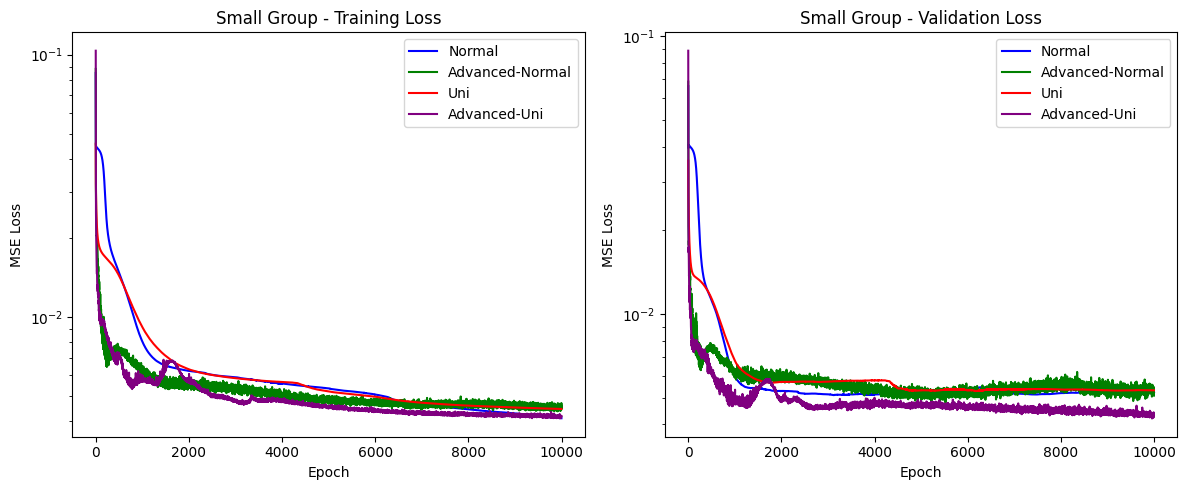

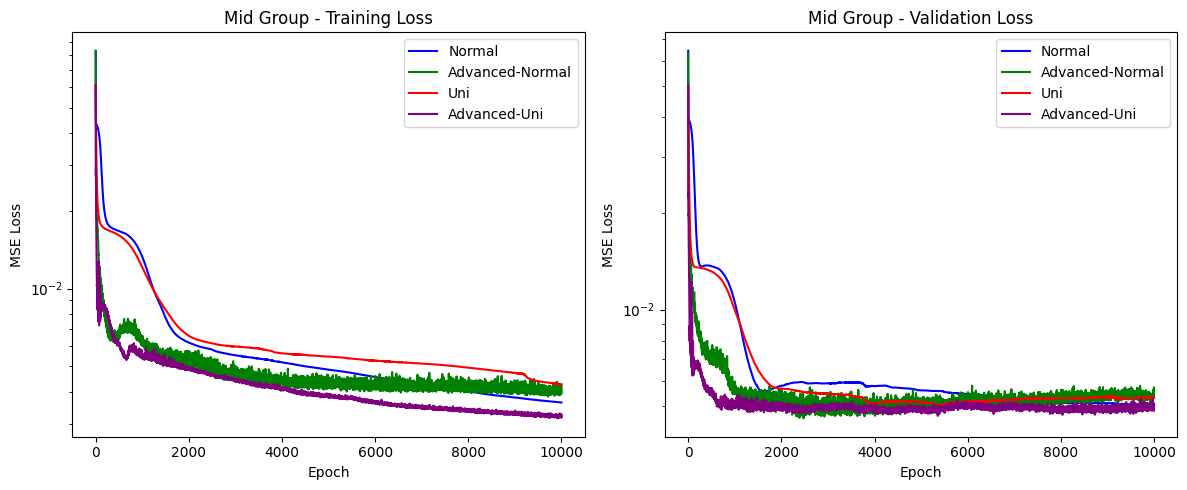

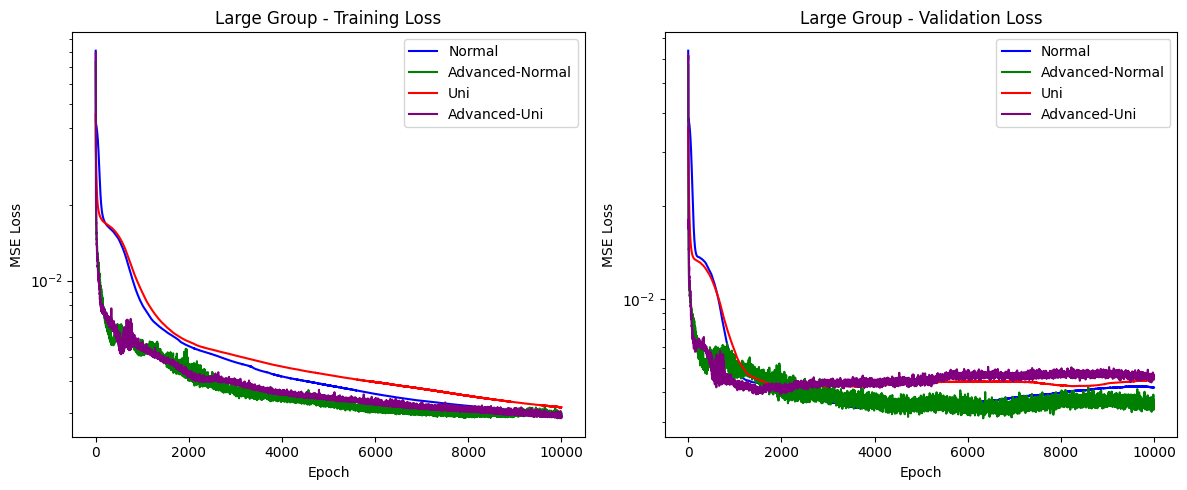

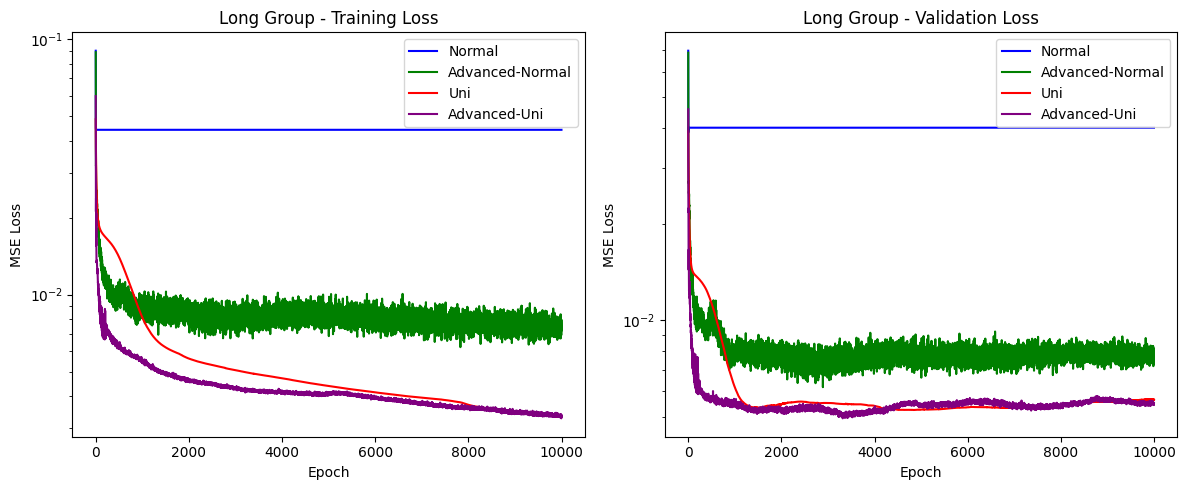

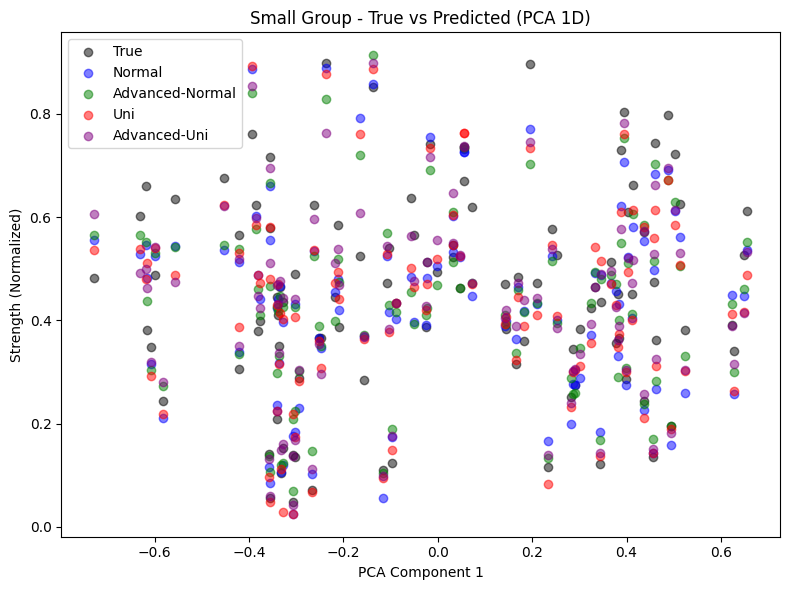

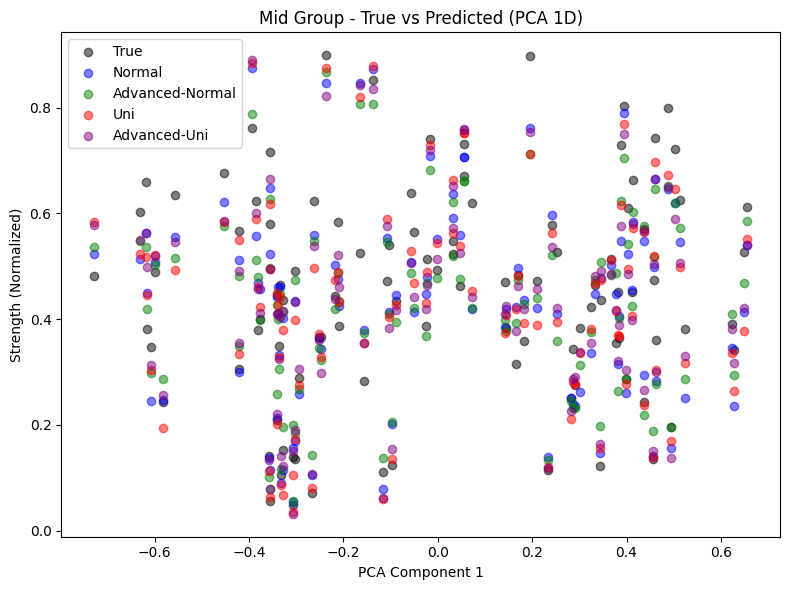

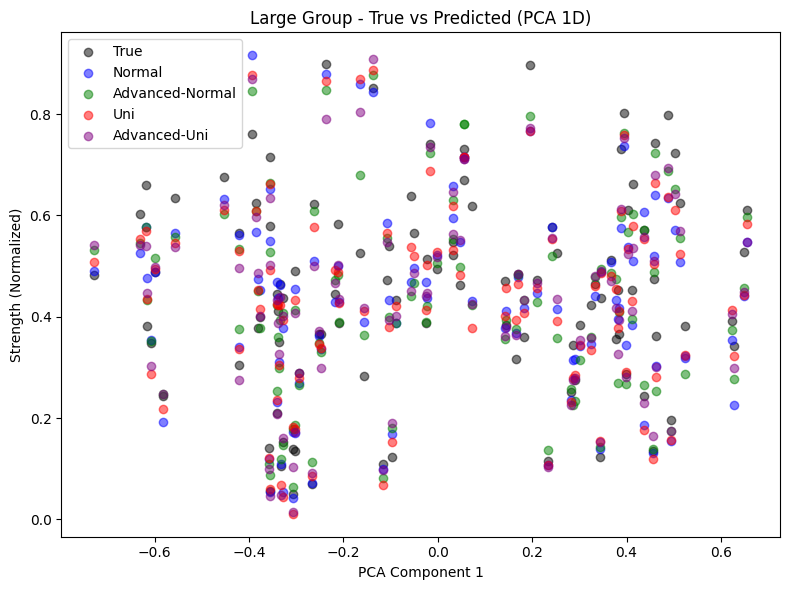

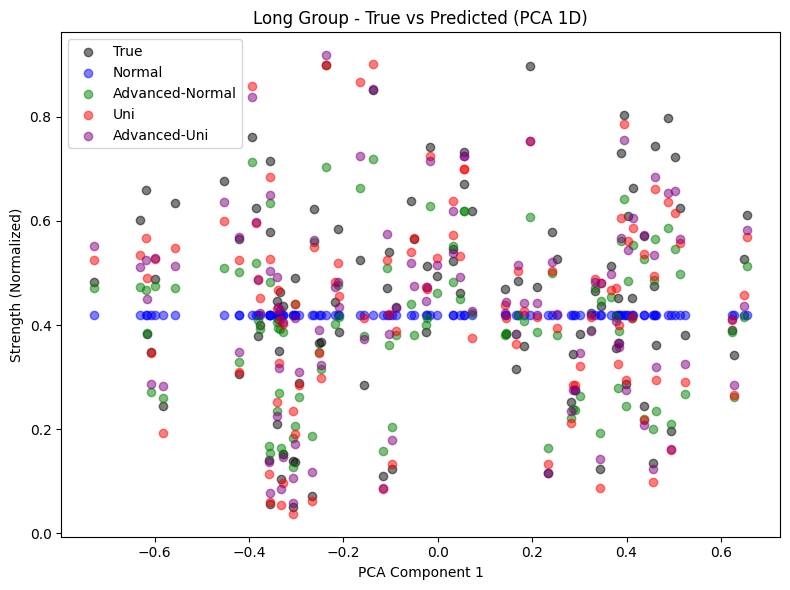

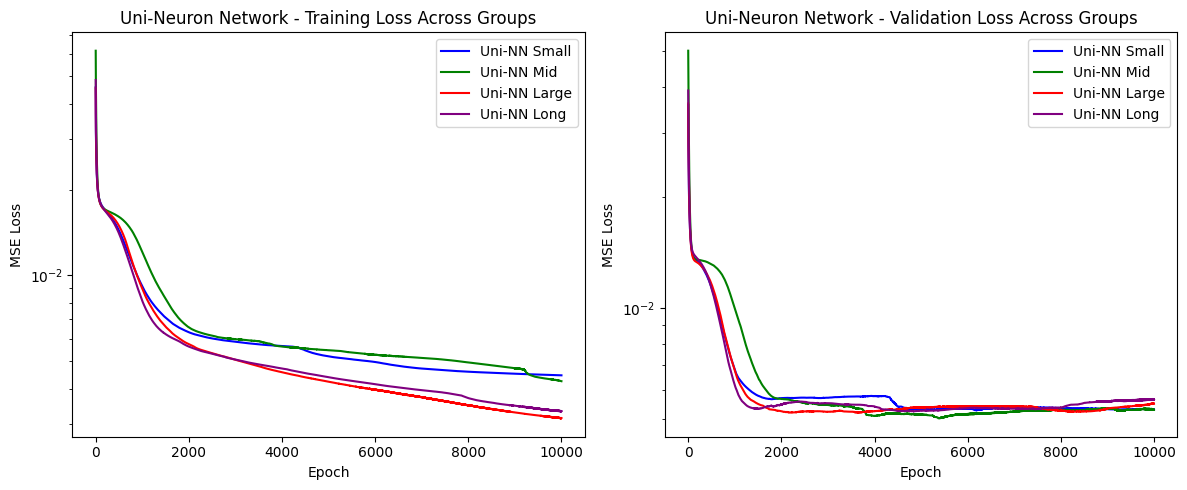


Baseline Linear Regression:
Test MSE: 0.0160, Test R²: 0.5890


Small Group Results:
Normal Network (Structure: [8, 10, 6, 1], 163 params):
Train MSE: 0.0041, Dev MSE: 0.0052, Test MSE: 0.0055
Train MAE: 0.0480, Dev MAE: 0.0560, Test MAE: 0.0591
Train R²: 0.9068, Dev R²: 0.8648, Test R²: 0.8587
Train Residual: 0.0480, Dev Residual: 0.0560, Test Residual: 0.0591
Time: 27.35s, Latency: 0.0000s, Overfit Gap: -0.0011
Advanced-Normal Network (Structure: [8, 10, 6, 1], 163 params):
Train MSE: 0.0045, Dev MSE: 0.0051, Test MSE: 0.0055
Train MAE: 0.0509, Dev MAE: 0.0561, Test MAE: 0.0588
Train R²: 0.8982, Dev R²: 0.8686, Test R²: 0.8579
Train Residual: 0.0509, Dev Residual: 0.0561, Test Residual: 0.0588
Time: 78.35s, Latency: 0.0001s, Overfit Gap: -0.0006
Uni Network (Structure: [8, 6, 6, 1], 165 params):
Train MSE: 0.0045, Dev MSE: 0.0053, Test MSE: 0.0062
Train MAE: 0.0496, Dev MAE: 0.0552, Test MAE: 0.0634
Train R²: 0.8989, Dev R²: 0.8627, Test R²: 0.8403
Train Residual: 0.0496, Dev Residu

In [18]:
# --- Visualizations ---
colors = {
    "Normal": "blue",
    "Advanced-Normal": "green",
    "Uni": "red",
    "Advanced-Uni": "purple",
    "Small": "blue",  # Colors for groups in Uni-NN comparison
    "Mid": "green",
    "Large": "red",
    "Long": "purple"
}
pca = PCA(n_components=1)
X_test_1d = pca.fit_transform(X_test)

# Group-wise Learning Curves
for group in networks:
    # Learning Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    for name, res in results[group].items():
        plt.plot(res["train_losses"], label=name, color=colors[name])
    plt.title(f"{group} Group - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.yscale("log")
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, res in results[group].items():
        plt.plot(res["dev_losses"], label=name, color=colors[name])
    plt.title(f"{group} Group - Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.yscale("log")
    plt.legend()
    plt.tight_layout()
    plt.show()

# PCA True vs Predicted (unchanged)
for group in networks:
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test_1d, Y_test, label="True", color="black", alpha=0.5)
    for name, net in networks[group].items():
        if name in ["Advanced-Normal", "Advanced-Uni"]:
            y_pred = net.forward(X_test, training=False)
        else:
            y_pred = net.forward(X_test)
        plt.scatter(X_test_1d, y_pred, label=name, color=colors[name], alpha=0.5)
    plt.title(f"{group} Group - True vs Predicted (PCA 1D)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("Strength (Normalized)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# New: Uni-Neuron Network Learning Curves Across All Groups
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for group in networks:
    res = results[group]["Uni"]
    plt.plot(res["train_losses"], label=f"Uni-NN {group}", color=colors[group])
plt.title("Uni-Neuron Network - Training Loss Across Groups")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.legend()

plt.subplot(1, 2, 2)
for group in networks:
    res = results[group]["Uni"]
    plt.plot(res["dev_losses"], label=f"Uni-NN {group}", color=colors[group])
plt.title("Uni-Neuron Network - Validation Loss Across Groups")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Results ---
print("\nBaseline Linear Regression:")
print(f"Test MSE: {lr_mse:.4f}, Test R²: {lr_r2:.4f}\n")

# Group-wise Results
for group in networks:
    print(f"\n{group} Group Results:")
    for name, net in networks[group].items():
        structure = net.layers
        num_params = net.count_parameters()
        print(f"{name} Network (Structure: {structure}, {num_params} params):")
        res = results[group][name]
        print(f"Train MSE: {res['train_loss']:.4f}, Dev MSE: {res['dev_loss']:.4f}, Test MSE: {res['test_loss']:.4f}")
        print(f"Train MAE: {res['train_mae']:.4f}, Dev MAE: {res['dev_mae']:.4f}, Test MAE: {res['test_mae']:.4f}")
        print(f"Train R²: {res['train_r2']:.4f}, Dev R²: {res['dev_r2']:.4f}, Test R²: {res['test_r2']:.4f}")
        print(f"Train Residual: {res['train_res']:.4f}, Dev Residual: {res['dev_res']:.4f}, Test Residual: {res['test_res']:.4f}")
        print(f"Time: {res['time']:.2f}s, Latency: {res['latency']:.4f}s, Overfit Gap: {res['overfit_gap']:.4f}")
    print()

# New: Uni-Neuron Network Results Across All Groups
print("\nUni-Neuron Network Results Across All Groups:")
for group in networks:
    net = networks[group]["Uni"]
    structure = net.layers
    num_params = net.count_parameters()
    print(f"Uni-NN {group} (Structure: {structure}, {num_params} params):")
    res = results[group]["Uni"]
    print(f"Train MSE: {res['train_loss']:.4f}, Dev MSE: {res['dev_loss']:.4f}, Test MSE: {res['test_loss']:.4f}")
    print(f"Train MAE: {res['train_mae']:.4f}, Dev MAE: {res['dev_mae']:.4f}, Test MAE: {res['test_mae']:.4f}")
    print(f"Train R²: {res['train_r2']:.4f}, Dev R²: {res['dev_r2']:.4f}, Test R²: {res['test_r2']:.4f}")
    print(f"Train Residual: {res['train_res']:.4f}, Dev Residual: {res['dev_res']:.4f}, Test Residual: {res['test_res']:.4f}")
    print(f"Time: {res['time']:.2f}s, Latency: {res['latency']:.4f}s, Overfit Gap: {res['overfit_gap']:.4f}")
    print()

---
#END
---

###Below are tested Advanced NN, but failed :(

In [ ]:
 # Advanced normal NN (Adam + BN + dropout)
class AdvancedNN:
    def __init__(self, layers, dropout_rates):
        self.layers = layers
        self.dropout_rates = dropout_rates
        self.weights = {}
        self.biases = {}
        self.bn_means = {}
        self.bn_vars = {}
        self.bn_gamma = {}
        self.bn_beta = {}
        self.m_w = {}  # Adam first moment for weights
        self.v_w = {}  # Adam second moment for weights
        self.m_b = {}  # Adam first moment for biases
        self.v_b = {}  # Adam second moment for biases

        # Initialize weights, biases, BN params, and Adam moments
        for i in range(len(layers)):
            for j in range(i + 1, len(layers)):
                self.weights[f'l{i}_l{j}'] = np.random.randn(layers[i], layers[j]) * 0.1
                self.m_w[f'l{i}_l{j}'] = np.zeros_like(self.weights[f'l{i}_l{j}'])
                self.v_w[f'l{i}_l{j}'] = np.zeros_like(self.weights[f'l{i}_l{j}'])
            if i > 0:
                self.biases[f'l{i}'] = np.zeros(layers[i])
                self.bn_means[f'l{i}'] = np.zeros(layers[i])
                self.bn_vars[f'l{i}'] = np.ones(layers[i])
                self.bn_gamma[f'l{i}'] = np.ones(layers[i])
                self.bn_beta[f'l{i}'] = np.zeros(layers[i])
                self.m_b[f'l{i}'] = np.zeros_like(self.biases[f'l{i}'])
                self.v_b[f'l{i}'] = np.zeros_like(self.biases[f'l{i}'])

    def forward(self, X, training=True):
        a = X
        self.activations = [a]
        self.drop_masks = []
        for i in range(len(self.layers) - 1):
            z = a @ self.weights[f'l{i}_l{i+1}'] + self.biases[f'l{i+1}']
            if i < len(self.layers) - 2:  # BN and Dropout for hidden layers
                if training:
                    mean = np.mean(z, axis=0)
                    var = np.var(z, axis=0)
                    self.bn_means[f'l{i+1}'] = 0.9 * self.bn_means[f'l{i+1}'] + 0.1 * mean
                    self.bn_vars[f'l{i+1}'] = 0.9 * self.bn_vars[f'l{i+1}'] + 0.1 * var
                z_norm = (z - self.bn_means[f'l{i+1}']) / np.sqrt(self.bn_vars[f'l{i+1}'] + 1e-8)
                z = self.bn_gamma[f'l{i+1}'] * z_norm + self.bn_beta[f'l{i+1}']
                a = np.maximum(0, z)
                if training and self.dropout_rates[i] > 0:
                    mask = np.random.binomial(1, 1 - self.dropout_rates[i], size=a.shape) / (1 - self.dropout_rates[i])
                    a *= mask
                    self.drop_masks.append(mask)
                else:
                    self.drop_masks.append(np.ones_like(a))
            else:
                a = z  # Linear output
            self.activations.append(a)
        return a

    def train(self, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, epochs, lr, batch_size):
      train_losses, dev_losses = [], []
      m = X_train.shape[0]
      start_time = time.time()
      beta1, beta2, eps = 0.9, 0.999, 1e-8  # Adam hyperparameters
      t = 0  # Time step for bias correction

      for epoch in range(epochs):
          for start in range(0, m, batch_size):
              end = min(start + batch_size, m)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]
              t += 1

              y_pred = self.forward(X_batch, training=True)
              dL_dout = (y_pred - Y_batch) / (end - start)

              grads_w = {}
              grads_b = {}
              grads_gamma = {}
              grads_beta = {}
              dL_dz = [None] * len(self.layers)
              dL_dz[-1] = dL_dout

              # Backprop through hidden layers
              for i in range(len(self.layers) - 2, 0, -1):
                  dL_dz[i] = dL_dz[i+1] @ self.weights[f'l{i}_l{i+1}'].T
                  if self.dropout_rates[i-1] > 0:
                      dL_dz[i] = dL_dz[i] * (self.activations[i] > 0) * self.drop_masks[i-1]
                  else:
                      dL_dz[i] = dL_dz[i] * (self.activations[i] > 0)
                  z_norm = (self.activations[i-1] @ self.weights[f'l{i-1}_l{i}'] + self.biases[f'l{i}'] - self.bn_means[f'l{i}']) / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)
                  grads_gamma[f'l{i}'] = np.sum(dL_dz[i] * z_norm, axis=0)
                  grads_beta[f'l{i}'] = np.sum(dL_dz[i], axis=0)
                  dL_dz[i] = dL_dz[i] * self.bn_gamma[f'l{i}'] / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)

              # Update weights and biases with Adam
              for i in range(len(self.layers)):
                  for j in range(i + 1, len(self.layers)):
                      if f'l{i}_l{j}' in self.weights:
                          grads_w[f'l{i}_l{j}'] = self.activations[i].T @ dL_dz[j]
                          self.m_w[f'l{i}_l{j}'] = beta1 * self.m_w[f'l{i}_l{j}'] + (1 - beta1) * grads_w[f'l{i}_l{j}']
                          self.v_w[f'l{i}_l{j}'] = beta2 * self.v_w[f'l{i}_l{j}'] + (1 - beta2) * (grads_w[f'l{i}_l{j}'] ** 2)
                          m_w_hat = self.m_w[f'l{i}_l{j}'] / (1 - beta1 ** t)
                          v_w_hat = self.v_w[f'l{i}_l{j}'] / (1 - beta2 ** t)
                          self.weights[f'l{i}_l{j}'] -= lr * m_w_hat / (np.sqrt(v_w_hat) + eps)
                  # Only update biases and BN params for hidden layers
                  if f'l{i}' in self.biases and i > 0 and i < len(self.layers) - 1:  # Exclude input and output layers
                      grads_b[f'l{i}'] = np.sum(dL_dz[i], axis=0)
                      self.bn_gamma[f'l{i}'] -= lr * grads_gamma[f'l{i}']
                      self.bn_beta[f'l{i}'] -= lr * grads_beta[f'l{i}']
                      self.m_b[f'l{i}'] = beta1 * self.m_b[f'l{i}'] + (1 - beta1) * grads_b[f'l{i}']
                      self.v_b[f'l{i}'] = beta2 * self.v_b[f'l{i}'] + (1 - beta2) * (grads_b[f'l{i}'] ** 2)
                      m_b_hat = self.m_b[f'l{i}'] / (1 - beta1 ** t)
                      v_b_hat = self.v_b[f'l{i}'] / (1 - beta2 ** t)
                      self.biases[f'l{i}'] -= lr * m_b_hat / (np.sqrt(v_b_hat) + eps)

          train_loss = mean_squared_error(Y_train, self.forward(X_train, training=False))
          dev_loss = mean_squared_error(Y_dev, self.forward(X_dev, training=False))
          train_losses.append(train_loss)
          dev_losses.append(dev_loss)

      test_loss = mean_squared_error(Y_test, self.forward(X_test, training=False))
      return train_losses, dev_losses, train_loss, dev_loss, test_loss, time.time() - start_time

    def count_parameters(self):
        total_params = 0
        for i in range(len(self.layers) - 1):
            total_params += self.layers[i] * self.layers[i+1]  # Weights
            total_params += self.layers[i+1]  # Biases
        return total_params

In [ ]:
# Advanced uni-NN -- Adam + BatchNorm + Dropout
class AdvUniNeuronNetwork:
    def __init__(self, layers, dropout_rates):
        self.layers = layers
        self.dropout_rates = dropout_rates
        self.weights = {}
        self.biases = {}
        self.bn_means = {}
        self.bn_vars = {}
        self.bn_gamma = {}
        self.bn_beta = {}
        self.m_w = {}  # Adam first moment (momentum)
        self.v_w = {}  # Adam second moment (RMSProp)
        self.m_b = {}
        self.v_b = {}
        for i in range(len(layers)):
            for j in range(i + 1, len(layers)):
                self.weights[f'l{i}_l{j}'] = np.random.randn(layers[i], layers[j]) * 0.1
                self.m_w[f'l{i}_l{j}'] = np.zeros_like(self.weights[f'l{i}_l{j}'])
                self.v_w[f'l{i}_l{j}'] = np.zeros_like(self.weights[f'l{i}_l{j}'])
            if i > 0:
                self.biases[f'l{i}'] = np.zeros(layers[i])
                self.bn_means[f'l{i}'] = np.zeros(layers[i])
                self.bn_vars[f'l{i}'] = np.ones(layers[i])
                self.bn_gamma[f'l{i}'] = np.ones(layers[i])
                self.bn_beta[f'l{i}'] = np.zeros(layers[i])
                self.m_b[f'l{i}'] = np.zeros(layers[i])
                self.v_b[f'l{i}'] = np.zeros(layers[i])

    def forward(self, X, training=True):
        self.activations = [X]
        self.zs = []
        self.drop_masks = []
        for i in range(1, len(self.layers)):
            z = sum(self.activations[j] @ self.weights[f'l{j}_l{i}']
                    for j in range(i) if f'l{j}_l{i}' in self.weights)
            z += self.biases[f'l{i}'] if f'l{i}' in self.biases else 0
            if i < len(self.layers) - 1:  # BN and Dropout for hidden layers
                if training:
                    mean = np.mean(z, axis=0)
                    var = np.var(z, axis=0)
                    self.bn_means[f'l{i}'] = 0.9 * self.bn_means[f'l{i}'] + 0.1 * mean
                    self.bn_vars[f'l{i}'] = 0.9 * self.bn_vars[f'l{i}'] + 0.1 * var
                z_norm = (z - self.bn_means[f'l{i}']) / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)
                z = self.bn_gamma[f'l{i}'] * z_norm + self.bn_beta[f'l{i}']
                a = np.maximum(0, z)
                if training and self.dropout_rates[i-1] > 0:
                    mask = np.random.binomial(1, 1 - self.dropout_rates[i-1], size=a.shape) / (1 - self.dropout_rates[i-1])
                    a *= mask
                    self.drop_masks.append(mask)
                else:
                    self.drop_masks.append(np.ones_like(a))
            else:
                a = z  # Linear output
            self.zs.append(z)
            self.activations.append(a)
        return self.activations[-1]

    def train(self, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, epochs, lr, batch_size):
      train_losses, dev_losses = [], []
      m = X_train.shape[0]
      start_time = time.time()
      beta1, beta2, eps = 0.9, 0.999, 1e-8  # Adam hyperparameters
      t = 0  # Time step for bias correction

      for epoch in range(epochs):
        for start in range(0, m, batch_size):
          end = min(start + batch_size, m)
          X_batch = X_train[start:end]
          Y_batch = Y_train[start:end]
          t += 1

          y_pred = self.forward(X_batch, training=True)
          dL_dout = (y_pred - Y_batch) / (end - start)

          grads_w = {}
          grads_b = {}
          grads_gamma = {}
          grads_beta = {}
          dL_dz = [None] * len(self.layers)
          dL_dz[-1] = dL_dout

          # Backprop through hidden layers
          for i in range(len(self.layers) - 2, 0, -1):
              dL_dz[i] = np.zeros((end - start, self.layers[i]))
              for j in range(i + 1, len(self.layers)):
                  if f'l{i}_l{j}' in self.weights:
                      dL_dz[i] += dL_dz[j] @ self.weights[f'l{i}_l{j}'].T

              if self.dropout_rates[i-1] > 0:
                  dL_dz[i] = dL_dz[i] * (self.activations[i] > 0) * self.drop_masks[i-1]
              else:
                  dL_dz[i] = dL_dz[i] * (self.activations[i] > 0)

              z_norm = (self.zs[i-1] - self.bn_means[f'l{i}']) / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)
              grads_gamma[f'l{i}'] = np.sum(dL_dz[i] * z_norm, axis=0)
              grads_beta[f'l{i}'] = np.sum(dL_dz[i], axis=0)
              dL_dz[i] = dL_dz[i] * self.bn_gamma[f'l{i}'] / np.sqrt(self.bn_vars[f'l{i}'] + 1e-8)

          # Update weights and biases with Adam
          for i in range(len(self.layers)):
              for j in range(i + 1, len(self.layers)):
                  if f'l{i}_l{j}' in self.weights:
                      grads_w[f'l{i}_l{j}'] = self.activations[i].T @ dL_dz[j]
                      self.m_w[f'l{i}_l{j}'] = beta1 * self.m_w[f'l{i}_l{j}'] + (1 - beta1) * grads_w[f'l{i}_l{j}']
                      self.v_w[f'l{i}_l{j}'] = beta2 * self.v_w[f'l{i}_l{j}'] + (1 - beta2) * (grads_w[f'l{i}_l{j}'] ** 2)
                      m_hat = self.m_w[f'l{i}_l{j}'] / (1 - beta1 ** t)
                      v_hat = self.v_w[f'l{i}_l{j}'] / (1 - beta2 ** t)
                      self.weights[f'l{i}_l{j}'] -= lr * m_hat / (np.sqrt(v_hat) + eps)
              if f'l{i}' in self.biases and i > 0 and i < len(self.layers) - 1:  # Only hidden layers
                  grads_b[f'l{i}'] = np.sum(dL_dz[i], axis=0)
                  if f'l{i}' in grads_gamma:  # Check if BN gradients exist
                      self.bn_gamma[f'l{i}'] -= lr * grads_gamma[f'l{i}']
                      self.bn_beta[f'l{i}'] -= lr * grads_beta[f'l{i}']
                  self.m_b[f'l{i}'] = beta1 * self.m_b[f'l{i}'] + (1 - beta1) * grads_b[f'l{i}']
                  self.v_b[f'l{i}'] = beta2 * self.v_b[f'l{i}'] + (1 - beta2) * (grads_b[f'l{i}'] ** 2)
                  m_hat = self.m_b[f'l{i}'] / (1 - beta1 ** t)
                  v_hat = self.v_b[f'l{i}'] / (1 - beta2 ** t)
                  self.biases[f'l{i}'] -= lr * m_hat / (np.sqrt(v_hat) + eps)

        train_loss = mean_squared_error(Y_train, self.forward(X_train, training=False))
        dev_loss = mean_squared_error(Y_dev, self.forward(X_dev, training=False))
        train_losses.append(train_loss)
        dev_losses.append(dev_loss)

      test_loss = mean_squared_error(Y_test, self.forward(X_test, training=False))
      return train_losses, dev_losses, train_loss, dev_loss, test_loss, time.time() - start_time

    def count_parameters(self):
        total_params = 0
        for i in range(len(self.layers)):
            for j in range(i + 1, len(self.layers)):
                if f'l{i}_l{j}' in self.weights:
                    total_params += self.layers[i] * self.layers[j]
        for i in range(1, len(self.layers)):
            total_params += self.layers[i]
        return total_params

